# Visualização dos dados tratados do AI Democracy

Nesse projeto estudamos as Atas do Diário da Assembléia de Portugal e tínhamos como ideia fazer uma ferramenta que mostrasse as estatísticas do uso de termos relacionados com a corrupção (aberto para mais temas futuramente), então fragmentamos cada Ata nos diálogos existentes e delimitamos um contexto que seria onde o Presidente abre e fecha uma determinada discussão sobre um ponto específico, seja uma declaração política ou debate de um Projeto de Lei.

# Importando Bibliotecas e Dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import bokeh
import re
from matplotlib.colors import *

In [2]:
# Os dados poderiam ser extraídos do Drive, mas achei mais fácil trabalhar localmente

projects = pd.read_csv("/content/projetos_assembleia.csv")

#CSV dos diálogos foi manualmente feito pelo André para teste do input
dialogs =  pd.read_csv("/content/atas_com_subject.csv")
dialogs.drop('Unnamed: 0', axis=1, inplace=True)
corruption_words = ['corrup',] #'corrupto', 'corrupta', 'corruptos', 'corruptas', 'corrupção', 'corrupções']

Sobre o dataset de projetos, trata-se de uma planilha que contém as Iniciativas Legislarivas, um pequeno texto descritivo extraído do site do projeto, o Título e o link para o site 

In [3]:
projects = pd.read_csv("/content/projetos_assembleia.csv")
projects.head(15)

,author,description,title,url
0,Luís Marques Mendes (PSD),Sobre a Agenda 2000,Projeto de Resolução 123/VII,https://www.parlamento.pt/ActividadeParlamenta...
1,"Luís Queiró (CDS-PP),Gonçalo Ribeiro da Costa ...",Conselhos municipais de acção social,Projeto de Lei 637/VII,https://www.parlamento.pt/ActividadeParlamenta...
2,"Pimenta Dias (PCP),Joaquim Matias (PCP),João A...",Isenta de emolumentos a apreciação das contas ...,Projeto de Lei 624/VII,https://www.parlamento.pt/ActividadeParlamenta...
3,"Luís Queiró (CDS-PP),Sílvio Rui Cervan (CDS-PP...","Pronuncia, acompanhamento e apreciação pela As...",Projeto de Lei 625/VII,https://www.parlamento.pt/ActividadeParlamenta...
4,Luís Queiró (CDS-PP),"Decreto-lei n° 15/99,de 15 de Janeiro, que""reg...",Apreciação Parlamentar 82/VII,https://www.parlamento.pt/ActividadeParlamenta...
5,Lino de Carvalho (PCP),Define princípios de referência para negociaçã...,Projeto de Resolução 122/VII,https://www.parlamento.pt/ActividadeParlamenta...
6,"João Amaral (PCP),Octávio Teixeira (PCP),Antón...",Altera o regime de instalação de novos municíp...,Projeto de Lei 622/VII,https://www.parlamento.pt/ActividadeParlamenta...
7,"Cabrita Neto (PSD),António Capucho (PSD)",Elevação à categoria de vila da povoação de Sa...,Projeto de Lei 621/VII,https://www.parlamento.pt/ActividadeParlamenta...
8,Jorge Valente (PS),Elevação da povoação de Alcantarilha no concel...,Projeto de Lei 617/VII,https://www.parlamento.pt/ActividadeParlamenta...
9,"Isabel Castro (PEV),Carmen Francisco (PEV)",Criação da rede publica de casas de apoio a mu...,Projeto de Lei 620/VII,https://www.parlamento.pt/ActividadeParlamenta...


In [4]:
dialogs

,Transcript,Date,Position,Person,Party,Text,Subject
0,DAR-001,17 DE SETEMBRO DE 2020,0,Presidente,NaN,Dirijo um abraço a todos neste regresso dos Pl...,declarações políticas 1
1,DAR-001,17 DE SETEMBRO DE 2020,1,Secretária,Maria da Luz Rosinha,"Sr. Presidente, muito boa tarde a todas e a to...",declarações políticas 1
2,DAR-001,17 DE SETEMBRO DE 2020,2,Presidente,NaN,"Como os Srs. Deputados estão a verificar, o an...",declarações políticas 1
3,DAR-001,17 DE SETEMBRO DE 2020,3,Secretária,Maria da Luz Rosinha,"Sr. Presidente, deram também entrada os Projet...",declarações políticas 1
4,DAR-001,17 DE SETEMBRO DE 2020,4,Presidente,NaN,"Muito obrigado, Sr.ª Secretária Maria da Luz R...",declarações políticas 2
...,...,...,...,...,...,...,...
11300,DAR-047,26 DE FEVEREIRO DE 2021,184,Presidente,António Filipe,Muito obrigado.,"Projeto de Resolução 899/XIV, Projeto de Resol..."
11301,DAR-047,26 DE FEVEREIRO DE 2021,185,Lara Martinho,PS,"Sr. Presidente, peço a palavra.","Projeto de Resolução 899/XIV, Projeto de Resol..."
11302,DAR-047,26 DE FEVEREIRO DE 2021,186,Presidente,António Filipe,"Para que efeito, Sr.ª Deputada?","Projeto de Resolução 899/XIV, Projeto de Resol..."
11303,DAR-047,26 DE FEVEREIRO DE 2021,187,Lara Martinho,PS,"Sr. Presidente, queria apenas informar a Mesa ...","Projeto de Resolução 899/XIV, Projeto de Resol..."


O dataset de diálogos conta com a ata que foi retirada a informação, a data, a posição desse diálogo, a pessoa que o disse, qual o partido e qual o texto e em qual contexto essa frase está inserida

In [5]:
dialogs.loc[dialogs['Person'] == 'Presidente', 'Party'] = np.NaN
dialogs.loc[dialogs['Person'] == 'Secretária', 'Party'] = np.NaN

Certo só arrumei que o Presidente e a Secretária estavam com os nomes como Partido.

In [6]:
dialogs.head()

,Transcript,Date,Position,Person,Party,Text,Subject
0,DAR-001,17 DE SETEMBRO DE 2020,0,Presidente,NaN,Dirijo um abraço a todos neste regresso dos Pl...,declarações políticas 1
1,DAR-001,17 DE SETEMBRO DE 2020,1,Secretária,NaN,"Sr. Presidente, muito boa tarde a todas e a to...",declarações políticas 1
2,DAR-001,17 DE SETEMBRO DE 2020,2,Presidente,NaN,"Como os Srs. Deputados estão a verificar, o an...",declarações políticas 1
3,DAR-001,17 DE SETEMBRO DE 2020,3,Secretária,NaN,"Sr. Presidente, deram também entrada os Projet...",declarações políticas 1
4,DAR-001,17 DE SETEMBRO DE 2020,4,Presidente,NaN,"Muito obrigado, Sr.ª Secretária Maria da Luz R...",declarações políticas 2


# Aplicando funções do André:

In [7]:
def find_words(data_frame, fields, words):
    series = [data_frame[field] for field in fields]
    positions = pd.DataFrame()
    for serie in series:
        for word in words:
            positions[serie.name+'_'+word+"_pos"] = serie.str.lower().str.find(word)
    return positions

def get_citations(data_frame, fields, words):
    positions = find_words(data_frame, fields, words)
    out_list = [] # pd.DataFrame(columns = data_frame.columns)
    i = 0
    for ind in positions.index:
        has_found = False
        for field_word in positions:
            if (positions[field_word][ind] != -1):
                has_found = True
                break
        if(has_found):
            #print(data_frame.iloc[ind].values)
            out_list.append(data_frame.iloc[ind].values)
            i = i + 1
    return pd.DataFrame(out_list, columns = data_frame.columns)

def get_related(full_dataframe, citation_dataframe, key_fields):
    citation_dataframe['key'] = citation_dataframe[key_fields[0]]
    full_dataframe['key'] = full_dataframe[key_fields[0]]
    for i in range(1, len(key_fields)):
        citation_dataframe['key'] = citation_dataframe['key'] + citation_dataframe[key_fields[i]]
        full_dataframe['key'] = full_dataframe['key'] + full_dataframe[key_fields[i]]
    topics = citation_dataframe['key'].unique()
    #print(topics)
    to_out = pd.DataFrame(columns = full_dataframe.columns)
    for topic in topics:
        to_out = to_out.append(full_dataframe.loc[full_dataframe['key'] == topic])
    return to_out

def get_related_projects(citations_df, projects_df):
    #print(citations_df['Subject'].unique())
    to_out = pd.DataFrame(columns = projects_df.columns)
    for subject in [str(sub) for sub in citations_df['Subject'].unique()]:
        #print('subject', subject)
        titles = subject.split(', ')
        for title in titles:
            to_out = to_out.append(projects_df.loc[projects_df['title'] == title])
    return to_out

dialogs_with_corruption_citations = get_citations(dialogs, ['Text'], corruption_words)
projects_with_corruption_citations = get_citations(projects, ['description'], corruption_words)
dialogs_related_to_corruption = get_related(dialogs, dialogs_with_corruption_citations, ['Date', 'Subject'])
projects_related_to_corruption = get_related_projects(dialogs_with_corruption_citations, projects)

print("Número de Diálogos diretamente ligados à corrupção:", len(dialogs_with_corruption_citations))
print("Número de Projetos diretamente ligados à corrupção:", len(projects_with_corruption_citations))
print("Número de Diálogos indiretamente ligados à corrupção:", len(dialogs_related_to_corruption))
print("Número de Projetos indiretamente ligados à corrupção:", len(projects_related_to_corruption))

dialogs_with_corruption_citations.to_csv('direct_citations.csv', index=False)
dialogs_related_to_corruption.to_csv('indirect_citations.csv', index=False)

Número de Diálogos diretamente ligados à corrupção: 89
Número de Projetos diretamente ligados à corrupção: 1
Número de Diálogos indiretamente ligados à corrupção: 2764
Número de Projetos indiretamente ligados à corrupção: 5


In [8]:
def clean(citations):
    not_politicians = ['Presidente', 'Secretária', 'Secretário', 'Ministra', 'Ministro']
    for not_politician in not_politicians:
        citations.loc[citations['Person'].str.contains(not_politician), 'Party'] = np.nan
    citations.dropna(axis=0, inplace=True)
    citations.replace(to_replace='Partido Socialista', value='PS', inplace=True)
    citations.replace(to_replace='SD', value=np.nan, inplace=True)
    citations.replace(to_replace='N insc.', value=np.nan, inplace=True)    
    return citations

dialogs_with_corruption_citations = clean(dialogs_with_corruption_citations)
dialogs_related_to_corruption = clean(dialogs_related_to_corruption)

#Gráficos

Existe uma ferramenta de gerar estatisticas globais, mas só com os datasets de relacionados e não relacionados podemos fazer alguns gráficos.

*   Mais informações sobre os partidos (alinhamento, tamanho, influência, logo, pessoas no parlamento...)
*   Mais informações sobre as pessoas (alinhamento, foto, projetos antigos com relação, ...)



In [9]:
def load_infos(custom_info_dict=None):
    if custom_info_dict == None:
            infos = {
                'PS'     : {
                    'color' : '#FF66FF',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido4_0.gif',
                    'coordinates' : (-2.5, 3.1),
                },
                'PSD'    : {
                    'color' : '#F68A21',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido3_1.gif',
                    'coordinates' : (1.6, -1),
                },
                'BE'     : {
                    'color' : '#D21F1B',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido14_0.gif',
                    'coordinates' : (-3.5, 0.5),
                },
                'PCP'    : {
                    'color' : '#FF0000',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido1_0.gif',
                    'coordinates' : (-3.5, -4.7),
                },
                'CDS-PP' : {
                    'color' : '#0091DC',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido2_0.gif',
                    'coordinates' : (2.5, -2.1),
                },
                'PAN'    : {
                    'color' : '#036A84',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/pan_2014.jpg',
                    'coordinates' : (-3.4, 3.2),
                },
                'PEV'    : {
                    'color' : '#73BE43',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido10_0.gif',
                    'coordinates' : (-2.1, -2.5),
                },
                'CH'     : {
                    'color' : '#333399',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_chega.png',
                    'coordinates' : (5, -3.6),
                },
                'IL'     : {
                    'color' : '#00AEEE',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_liberal.png',
                    'coordinates' : (1, 0.5) #???,
                },
                'JPP'    : {
                    'color' : '#0E766D',
                    'orientation' : 'Centro',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_jpp.jpg',
                    'coordinates' : (0, 0) #???,
                },
                'PPM'    : {
                    'color' : '#014A94',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido5_0.gif',
                    'coordinates' : (1.25, -2.1) #???,
                },
                'NC'     : {
                    'color' : '#FEAB19',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_nos_cidadaos.jpg',
                    'coordinates' : (0, 0.9) #???,
                },
                'L'      : {
                    'color' : '#98C75A',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/livre.png',
                    'coordinates' : (-4.6, 2.7),
                },
            }
            return infos
    else:
        return custom_info_dict

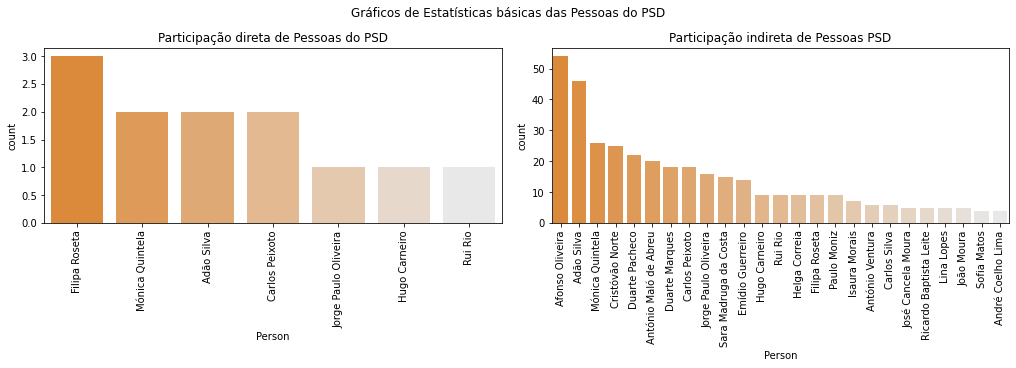

In [10]:
def persons_byparty_statistics(direct_citations, indirect_citations, party, number=25, infos=load_infos()):
    direct_party = direct_citations.loc[direct_citations['Party'] == party]
    indirect_party = indirect_citations.loc[indirect_citations['Party'] == party]

    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(14,5))
    fig.suptitle('Gráficos de Estatísticas básicas das Pessoas do {}'.format(party))
    axs[0].set_title('Participação direta de Pessoas do {}'.format(party))
    axs[1].set_title('Participação indireta de Pessoas {}'.format(party))

    party_color = infos[party]['color']
    
    if len(direct_party) >= number:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=number)
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[0], x='Person',
                data= direct_party,
                palette=cmap,
                order=direct_party['Person'].value_counts().iloc[:number].index)
    else:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=len(direct_party['Person'].unique()))
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[0], x='Person',
                data= direct_party,
                palette=cmap,
                order=direct_party['Person'].value_counts().iloc[:number].index)
        
    if len(indirect_party) >= number:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=number)
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[1], x='Person',
                data= indirect_party,
                palette=cmap,
                order=indirect_party['Person'].value_counts().iloc[:number].index)
    else:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=len(indirect_party['Person'].unique()))
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[1], x='Person',
                data= indirect_party,
                palette=cmap,
                order=indirect_party['Person'].value_counts().iloc[:number].index)
    
    axs[0].tick_params(axis='x', rotation=90)
    axs[1].tick_params(axis='x', rotation=90)
    plt.show()

persons_byparty_statistics(dialogs_with_corruption_citations, dialogs_related_to_corruption, 'PSD')

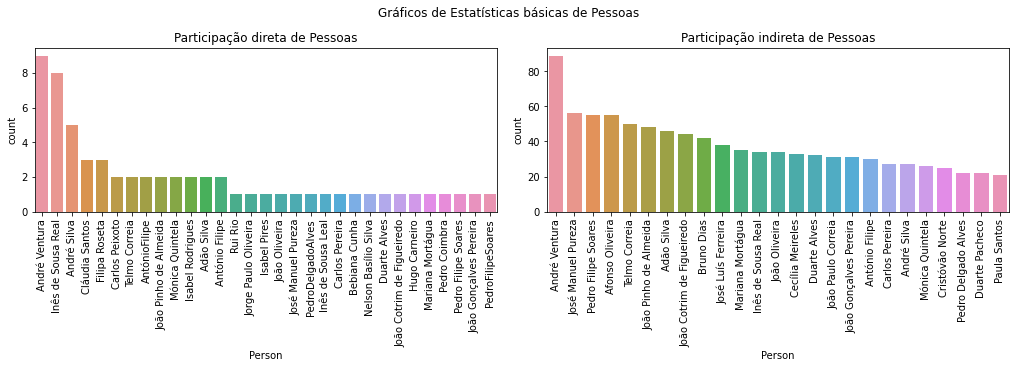

In [11]:
def people_statistics(direct_citations, indirect_citations, number=25):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(14,5))
    fig.suptitle('Gráficos de Estatísticas básicas de Pessoas')
    axs[0].set_title('Participação direta de Pessoas')
    axs[1].set_title('Participação indireta de Pessoas')
    sns.countplot(ax=axs[0], x='Person', data= direct_citations, order=direct_citations['Person'].value_counts().index)
    sns.countplot(ax=axs[1], x='Person', data= indirect_citations[-(indirect_citations['Person'] == 'Presidente')],
                  order=indirect_citations['Person'].value_counts().iloc[:number].index)
    axs[0].tick_params(axis='x', rotation=90)
    axs[1].tick_params(axis='x', rotation=90)
    plt.show()

people_statistics(dialogs_with_corruption_citations, dialogs_related_to_corruption)

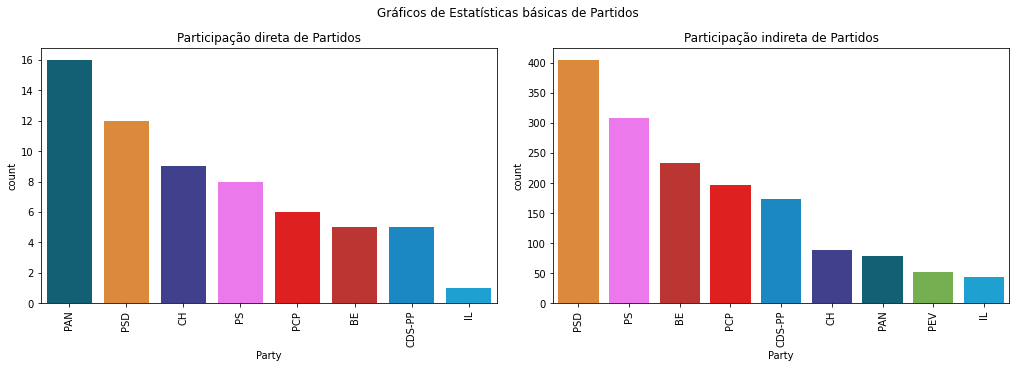

In [12]:
def parties_statistics(direct_citations, indirect_citations, infos=load_infos()):
    
    party_colors = {}
    for party in infos:
        party_colors[party] = infos[party]['color']
    
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(14,5))
    fig.suptitle('Gráficos de Estatísticas básicas de Partidos')
    axs[0].set_title('Participação direta de Partidos')
    axs[1].set_title('Participação indireta de Partidos')

    sns.countplot(ax=axs[0], x='Party',
                  data= direct_citations, palette=party_colors,
                  order=direct_citations['Party'].value_counts().index)
    
    sns.countplot(ax=axs[1], x='Party', 
                  data= indirect_citations, palette=party_colors,
                  order=indirect_citations['Party'].value_counts().index)

    axs[0].tick_params(axis='x', rotation=90)
    axs[1].tick_params(axis='x', rotation=90)
    
    plt.show()

parties_statistics(dialogs_with_corruption_citations, dialogs_related_to_corruption)

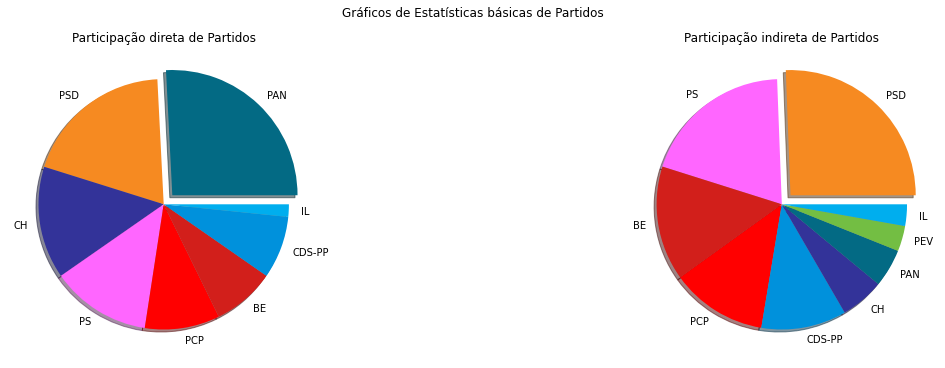

In [13]:
def parties_statistics_pie(direct_citations, indirect_citations, infos=load_infos()):
    
    party_colors = {}
    for party in infos:
        party_colors[party] = infos[party]['color']
    
    fig, axs = plt.subplots(1, 2, sharey=True, 
                            constrained_layout=True, 
                            figsize=(17,5))
    fig.suptitle('Gráficos de Estatísticas básicas de Partidos')
    axs[0].set_title('Participação direta de Partidos')
    axs[1].set_title('Participação indireta de Partidos')

    direct_parties = {
        'Parties' : [],
        '# Citations' : [],
    }
    indirect_parties = {
        'Parties' : [],
        '# Citations' : [],
    }

    for party in direct_citations['Party'].unique().tolist():
        if str(party) != str(np.nan):
            direct_parties['Parties'].append(party)
            direct_parties['# Citations'].append(len(direct_citations.loc[direct_citations['Party'] == party]))

    for party in indirect_citations['Party'].unique().tolist():
        if str(party) != str(np.nan):
            indirect_parties['Parties'].append(party)
            indirect_parties['# Citations'].append(len(indirect_citations.loc[indirect_citations['Party'] == party]))


    direct_parties = pd.DataFrame.from_dict(direct_parties).sort_values(by=['# Citations'], ascending=False)
    indirect_parties = pd.DataFrame.from_dict(indirect_parties).sort_values(by=['# Citations'], ascending=False)

    labels = direct_parties['Parties'].unique()

    axs[0].pie(x='# Citations', labels=labels,
               shadow=True, startangle=0, 
               explode=[0.1]+[0]*(len(direct_parties)-1), 
               data=direct_parties,
               colors=[party_colors[key] for key in labels])

    labels = indirect_parties['Parties'].unique()

    axs[1].pie(x='# Citations', labels=labels,
               shadow=True, startangle=0, 
               explode=[0.1]+[0]*(len(indirect_parties)-1), 
               data=indirect_parties,
               colors=[party_colors[key] for key in labels])

    plt.show()

parties_statistics_pie(dialogs_with_corruption_citations, dialogs_related_to_corruption)

Tabela com as informações de quem é presente na XIV legislatura: [aqui](https://pt.wikipedia.org/wiki/Lista_de_deputados_de_Portugal_(XIV_Legislatura)

Tabela com as orientações de cada partido: [aqui](https://pt.wikipedia.org/wiki/Lista_de_partidos_pol%C3%ADticos_em_Portugal#:~:text=No%20pa%C3%ADs%20dominam%20cinco%20grandes,e%20democrata%2Dcrist%C3%A3o%3B%20e%20o)

